In [116]:
import os
import sys
# add the src directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

from ttt_pyttt import PyTTT
from utils import plot_traces
import numpy as np
from matplotlib import pyplot as plt

# Example 4: Traffic light with pedestrian crossing

```mermaid
    graph TB
        car_red_start_after_yellow2("r+")
        car_red_end_after_yellow2("r-")
        is_red("r")
        car_yellow1_start_after_red("y+")
        car_yellow1_end_after_red("y-")
        is_yellow1("y1")
        car_yellow2_start_after_green("y+")
        car_yellow2_end_after_green("y-")
        is_yellow2("y2")
        is_yellow("y")
        car_green_start_after_yellow1("g+")
        car_green_end_after_yellow1("g-")
        is_green("g")

        ped_request("p_req")

        ped_is_red("p_r")
        ped_green_start("p_g+")
        ped_green_end("p_g-")
        ped_is_green("p_g")


        car_red_start_after_yellow2 --o is_red
        car_red_end_after_yellow2 --> is_red

        is_red --> car_yellow1_start_after_red
        is_red --> car_yellow1_end_after_red

        car_yellow1_start_after_red --o is_yellow1
        car_yellow1_end_after_red --> is_yellow1

        is_yellow1 --> car_green_start_after_yellow1
        is_yellow1 --> car_green_end_after_yellow1

        car_green_start_after_yellow1 --o is_green
        car_green_end_after_yellow1 --> is_green

        is_green --> car_yellow2_start_after_green
        is_green --> car_yellow2_end_after_green

        car_yellow2_start_after_green --o is_yellow2
        car_yellow2_end_after_green --> is_yellow2

        is_yellow2 --> car_red_start_after_yellow2
        is_yellow2 --> car_red_end_after_yellow2

        is_yellow1 --> is_yellow
        is_yellow2 --> is_yellow

        is_red --> ped_green_start
        is_red --> ped_green_end
        is_red --> ped_is_red
        
        ped_pending --> ped_green_start
        ped_pending --> ped_green_end
        

        car_red_start_after_yellow2 --o ped_pending
        car_red_end_after_yellow2 --> ped_pending
        ped_request --> ped_pending

        ped_green_start --o ped_is_green
        ped_green_end --> ped_is_green

        ped_is_green --o ped_is_red
        ped_is_green --o ped_request
        ped_is_green --o ped_pending
```
a

In [117]:
# construct model:
# 19 nodes: 3 each for the 4 phases of the car traffic light, one for the yellow phase, 3 for the green phase of the pedestrian traffic light, 1 for pedestrian red, 1 for the request to pass, 1 for pending pedestrian green
# c_r_s, c_r_e, c_r, c_y1_s, c_y1_e, c_y1, c_y2_s, c_y2_e, c_y2, c_y, c_g_s, c_g_e, c_g, p_r, p_g_s, p_g_e, p_g, p_req, p_pend

good_thresh = np.ones((19, ))
# the pedestrian red is always on by default
good_thresh[13] = 0
# the pedestrian green light requires a request and the right phase
good_thresh[14:16] = 2
# the pedestrian pending requires a request and the right phase
good_thresh[18] = 2

bad_thresh = np.zeros((19, ))

W_good = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r_s
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r_e
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1_s
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1_e
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # c_y2_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # c_y2_e
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y2
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_g_s
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_g_e
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # c_g
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # p_r
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # p_g_s
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # p_g_e
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # p_g
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # p_req
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # p_pend
    ]
)

W_bad = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r_e
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_r
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1_e
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y1
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y2_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y2_e
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y2
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_y
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_g_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # c_g_e
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # c_g
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # p_r
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # p_g_s
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # p_g_e
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # p_g
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # p_req
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # p_pend
    ]
)

# pulse durations:
red_phase = 300
yellow_phase1 = 20
yellow_phase2 = 20
green_phase = 300
ped_wait_phase = 50
ped_green_phase = 150
pending = 1

total_duration = red_phase + yellow_phase1 + green_phase + yellow_phase2

pulse_duration = np.array(
    [
        yellow_phase2,
        yellow_phase2 + 1,
        red_phase,
        red_phase,
        red_phase + 1,
        yellow_phase1,
        green_phase,
        green_phase + 1,
        yellow_phase2,
        1,
        yellow_phase1,
        yellow_phase1 + 1,
        green_phase,
        total_duration,
        ped_wait_phase,
        ped_wait_phase + 1,
        ped_green_phase,
        total_duration,
        pending
    ]
)

net = PyTTT(goodThreshold=good_thresh, badThreshold=bad_thresh, W_good=W_good, W_bad=W_bad, duration=pulse_duration)

In [118]:
# generate input
num_steps = 3000
dt = 0.1
steps = np.arange(num_steps)*dt

good_tokens_in = np.zeros((num_steps, len(good_thresh)), dtype=np.int32)
bad_tokens_in = np.zeros((num_steps, len(good_thresh)), dtype=np.int32)

# start the traffic light
good_tokens_in[0, 2] = 1

# request after 500 and 1550, 1575, 1600
good_tokens_in[[500, 1550, 1575, 1600], -2] = 1

# give each input signal a duration of 1ms
PyTTT.set_expiration(good_tokens_in, 1, circular=False)

# run and keep track of the generated EPSPs, spikes and plateaus
did_start = np.zeros_like(good_tokens_in, dtype=np.int32)
did_stop = np.zeros_like(good_tokens_in, dtype=np.int32)
for step,(start_token, stop_token) in enumerate(net.run(good_tokens_in, bad_tokens_in)):
    did_start[step,:] = start_token
    did_stop[step,:] = stop_token


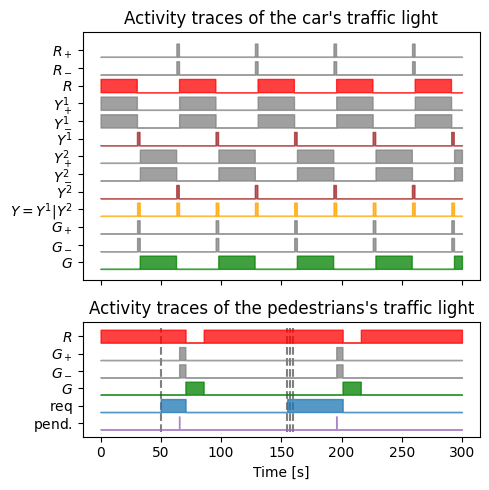

In [123]:
fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[13, 6], figsize=(5, 5))
colors = [
    "gray", "gray", "red", 
    "gray", "gray", "brown",
    "gray", "gray", "brown",
    "orange",
    "gray", "gray", "green",
    "red", 
    "gray", "gray", "green",
    "C0",
    "C4"
]
labels = [
    r"$R_+$", r"$R_-$", r"$R$",
    r"$Y_+^1$", r"$Y_-^1$", r"$Y^1$",
    r"$Y_+^2$", r"$Y_-^2$", r"$Y^2$",
    r"$Y=Y^1 | Y^2$",
    r"$G_+$", r"$G_-$", r"$G$",
    r"$R$",
    r"$G_+$", r"$G_-$", r"$G$",
    r"$\text{req}$",
    r"$\text{pend.}$",
]

ax[1].vlines(steps[[500, 1550, 1575, 1600]], 0.5, 6.5, color="gray", linestyle="--", zorder=0)

ax[0].set_title("Activity traces of the car's traffic light")
ax[1].set_title("Activity traces of the pedestrians's traffic light")
ax[1].set_xlabel("Time [s]")
plot_traces(steps, did_start[:,:13], did_stop[:,:13], ax=ax[0], colors=colors[:13], labels=labels[:13], alpha=0.75, zorder=10)
plot_traces(steps, did_start[:,13:], did_stop[:,13:], ax=ax[1], colors=colors[13:], labels=labels[13:], alpha=0.75, zorder=10)

fig.tight_layout()

fig.savefig("traffic_light.png", dpi=300, bbox_inches="tight")
fig.savefig("traffic_light.svg", dpi=300, bbox_inches="tight")
fig.savefig("traffic_light.pdf", dpi=300, bbox_inches="tight")